Please run the script under \*nix system with `FFmpeg` installed (for generating the video). Before running the code, please make sure the following Python libary are installed:

`jupyter`, `pandas`, `numpy`, `matplotlib`, `xgboost`, `scikit-learn`, `beautifulsoup`, `requests`, `seaborn`, `joblib`

Then use `jupyter notebook` command to start the jupyter notebook server and open the .ipynb file.


# Question 1

### a. Programmatically download and load into your favorite analytical tool the trip data for September 2015.

In [74]:
def download_logfiles(contained_str):
    '''
    contained_str: a list of str that the target filename contains
    '''
    def check_contained_str(log_link):
        for c_str in contained_str:
            if log_link.find(c_str) < 0:
                return False
        return True
        
    import requests
    import urllib
    from bs4 import BeautifulSoup, SoupStrainer
    
    url = 'http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml'
    soup = BeautifulSoup(requests.get(url).text, parse_only=SoupStrainer('a', href=True))
    log_links = [link['href'] for link in soup.find_all('a')]
    log_links = [log_link for log_link in log_links if check_contained_str(log_link)]
    
    filenames = []
    for log_link in log_links:
        filename = log_link.split('/')[-1]
        urllib.urlretrieve(log_link, filename)
        print 'Successful downloaded ', filename
        filenames.append(filename)
    
    return filenames

In [75]:
import pandas as pd
filename = download_logfiles(['green', '2015', '09', '.csv'])[0]

df = pd.read_csv(filename, sep=',')

Successful downloaded  green_tripdata_2015-09.csv


### b. Report how many rows and columns of data you have loaded.

In [76]:
print 'There are',df.shape[0],'rows and',df.shape[1],'columns in the downloaded dataset.'

There are 1494926 rows and 21 columns in the downloaded dataset.


In [77]:
print 'The variables include:\n',',\n'.join([x.strip() for x in df.columns])

The variables include:
VendorID,
lpep_pickup_datetime,
Lpep_dropoff_datetime,
Store_and_fwd_flag,
RateCodeID,
Pickup_longitude,
Pickup_latitude,
Dropoff_longitude,
Dropoff_latitude,
Passenger_count,
Trip_distance,
Fare_amount,
Extra,
MTA_tax,
Tip_amount,
Tolls_amount,
Ehail_fee,
improvement_surcharge,
Total_amount,
Payment_type,
Trip_type


# Question 2

### a. Plot a histogram of the number of the trip distance ("Trip Distance").

In [78]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


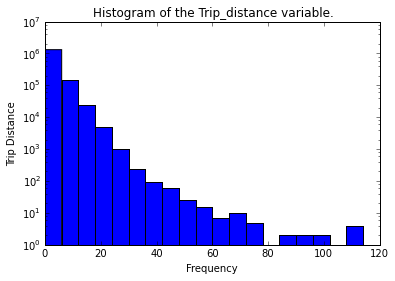

In [79]:
hist(df.Trip_distance, log=True, range=[0,120], bins=20)
pyplot.title('Histogram of the Trip_distance variable.')
pyplot.xlabel('Frequency')
pyplot.ylabel('Trip Distance')

### b. Report any structure you find and any hypotheses you have about that structure.

In [80]:
df.Trip_distance.describe()

count    1494926.000000
mean           2.968141
std            3.076621
min            0.000000
25%            1.100000
50%            1.980000
75%            3.740000
max          603.100000
Name: Trip_distance, dtype: float64

In [81]:
def get_d_distribution(d_dat):
    '''
    To calculate the distribution of d, since it presents long-tail properties, it's
    not wise to draw it on a linear coordinate system. 
    Therefore I will plot it in a log-linear coordinate system.
    On the other hand, to avoid the noisy tail of log-linear plot, I use the so-called
    logarithmic-binning to get the probability denssity distribution.
    '''
    import math
    logres = 10.0
    min_resolution = 1  # min = 100m
    base = 10.0  # or use math.e
    maxloglen = 100

    distrib = [0.0] * maxloglen

    for d in d_dat:
        quantity = d
        if quantity < min_resolution:
            continue
        quantity_index = int(math.log(quantity / min_resolution, base) * logres)
        distrib[quantity_index] += 1.0
    count = sum(distrib)
    x_list, p_list = [], []
    for j in xrange(maxloglen):
        if distrib[j] > 0.5:
            x = math.pow(base, (j + 0.5) / logres)
            p = (distrib[j] / count /
                 (math.pow(base, (j+1.0) / logres) -
                  math.pow(base, float(j) / logres)))
            x_list.append(x)
            p_list.append(p)
    return (x_list, p_list)

In [82]:
d_dat = list(df.Trip_distance[df.Trip_distance>0]*10)
d_distrib = get_d_distribution(d_dat)

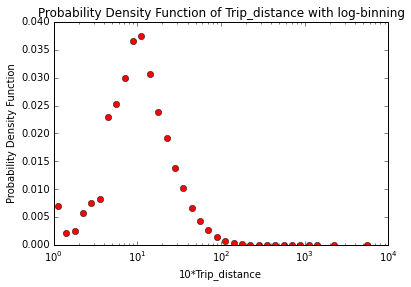

In [83]:
plot(d_distrib[0], d_distrib[1], 'ro')
xscale('log')
pyplot.title('Probability Density Function of Trip_distance with log-binning')
pyplot.ylabel('Probability Density Function')
pyplot.xlabel('10*Trip_distance')
show()

From the above plot, it is easy to find log(10\*Trip_distance) approximately follows a normal distribution. Thus the variable Trip_distance should follow a **lognormal distribution** (probability density function). If given more time, I will use maximum-likelihood method to get the parameters of the lognormal distribution.

# Question 3

### a. Report mean and median trip distance grouped by hour of day.

In [84]:
df['hour_of_day']=((pd.to_datetime(df.Lpep_dropoff_datetime)-pd.to_datetime(df.lpep_pickup_datetime))/2
                   +pd.to_datetime(df.lpep_pickup_datetime)).apply(lambda x: x.hour)
hour_groups = df[['hour_of_day','Trip_distance']].groupby('hour_of_day')

In [85]:
print 'The mean trip distance grouped by hour of day (0 to 23):'
hour_groups.mean()

The mean trip distance grouped by hour of day (0 to 23):


,Trip_distance
hour_of_day,
0,3.183713
1,3.062710
2,3.092803
3,3.206705
4,3.517394
5,4.117403
6,3.936409
7,3.253702
8,2.993109


In [86]:
print 'The median trip distance grouped by hour of day (0 to 23):'
hour_groups.median()

The median trip distance grouped by hour of day (0 to 23):


,Trip_distance
hour_of_day,
0,2.24
1,2.16
2,2.19
3,2.22
4,2.38
5,2.84
6,2.78
7,2.10
8,1.92


### b. We'd like to get a rough sense of identifying trips that originate or terminate at one of the NYC area airports. Can you provide a count of how many transactions fit this criteria, the average fair, and any other interesting characteristics of these trips.

One of NYC area airport is the LaGuardia Airport, which is located at 40.77472° N, 73.87194° W. Here I used the Haversine formula to calculate the great-circle distances between two points on a sphere (earth) from their longitudes and latitudes. Then I can calculate the distance between the pick-up (orrop-off) location and the airport location. If one of the (pick-up and drop-of) distances is smaller than 0.7 miles in a transaction, I identify it as a trip originate or terminate at LaGuardia Airport.

In [87]:
LaGuardia_Airport =[40.7723628,-73.8733684]

In [88]:
import math
def distance(A, B):
    lat1, lon1 = A
    lat2, lon2 = B
    R = 6371000/1609.34  #in miles
    Haversine = (math.sin(math.radians((lat2 - lat1) / 2)))**2 + \
        math.cos(math.radians(lat1)) * \
        math.cos(math.radians(lat2)) * \
        (math.sin(math.radians((lon2 - lon1) / 2)))**2
    d = R * 2 * math.atan2(math.sqrt(Haversine), math.sqrt(1 - Haversine))
    return d

In [89]:
df['pickup_airport_distance'] = map(lambda A: distance(A, LaGuardia_Airport),
                                    zip(df.Pickup_latitude, df.Pickup_longitude))
df['dropoff_airport_distance'] = map(lambda A: distance(A, LaGuardia_Airport),
                                     zip(df.Dropoff_latitude, df.Dropoff_longitude))
close_to_airport=df[(df.pickup_airport_distance<0.7) | (df.dropoff_airport_distance<0.7)]

print len(close_to_airport)

Thus, there are 27300 transactions that involve trips originate or terminate at LaGuardia Airport in the September of 2015.

In [93]:
avg_fare=close_to_airport.Total_amount.mean()
print 'The average fare of the trips originate or terminate at LaGuardia Airport is %.2f USD.'%avg_fare

The average fare of the trips originate or terminate at LaGuardia Airport is 23.90 USD.


In [94]:
avg_dis=close_to_airport.Trip_distance.mean()
print 'The average distance of the trips originate or terminate at LaGuardia Airport is %.2f miles.'%avg_dis

The average distance of the trips originate or terminate at LaGuardia Airport is 5.66 miles.


In [95]:
close_to_airport.Passenger_count.value_counts()

1    22805
2     2170
5     1195
3      546
6      385
4      194
0        5
Name: Passenger_count, dtype: int64

Above shows the counts of trips related to LaGuardia Airport in September 2015 when the trips are grouped by number of passengers.

# Question 4

For this problem, I used the Extreme Gradient Boosting (xgboost) method for taxi tip-percentage prediciton. I compared several algorithms, and found xgboost gives the best accuracy performance. If given more time, I will implement cross validation and grid search for parameters.

### a. Build a derived variable for tip as a percentage of the total fare.

In [96]:
df['tip_percent'] = df.Tip_amount/df.Total_amount * 100

### b. Build a predictive model for tip as a percentage of the total fare. Use as much of the data as you like (or all of it). We will validate a sample.

Generated Feature 1: trip_duration (continuous)

In [ ]:
trip_dur= pd.to_datetime(df.Lpep_dropoff_datetime)-pd.to_datetime(df.lpep_pickup_datetime)
df['trip_duration']=[int(x.total_seconds()) for x in trip_dur]

Generated Feature 2: Pickup_density (continuous)

Generated Feature 3: Dropoff_density (continuous)

In [99]:
valid_latlon = df[(df.Pickup_latitude>0)&
                  (df.Dropoff_latitude>0)][['Pickup_latitude','Pickup_longitude',
                                            'Dropoff_latitude', 'Dropoff_longitude']]

positions = zip(df.Pickup_latitude, df.Pickup_longitude) + zip(df.Dropoff_latitude, df.Dropoff_longitude)

min_lat = min(min(valid_latlon.Pickup_latitude),min(valid_latlon.Dropoff_latitude)) - 0.000001
max_lat = max(max(valid_latlon.Pickup_latitude),max(valid_latlon.Dropoff_latitude)) + 0.000001
min_lon = min(min(valid_latlon.Pickup_longitude),min(valid_latlon.Dropoff_longitude)) - 0.000001
max_lon = max(max(valid_latlon.Pickup_longitude),max(valid_latlon.Dropoff_longitude)) + 0.000001

resolution_lat, resolution_lon = (max_lat-min_lat)/2000, (max_lon-min_lon)/2000

count = np.zeros([2000,2000],dtype=int)
def get_coordinate(latlon):
    if latlon[0] == 0 or latlon[1] == 0:
        return -1
    return int((latlon[0]-min_lat)/resolution_lat),int((latlon[1]-min_lon)/resolution_lon)

for latlon in positions:
    coord = get_coordinate(latlon)
    if coord != -1:
        count[coord] += 1

df['Pickup_density'] = map(lambda x: 0 if get_coordinate(x) == -1 else count[get_coordinate(x)],
                           zip(df.Pickup_latitude, df.Pickup_longitude))

df['Dropoff_density'] = map(lambda x: 0 if get_coordinate(x) == -1 else count[get_coordinate(x)],
                           zip(df.Dropoff_latitude, df.Dropoff_longitude))

In [102]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor

Generated Feature 4: hour_of_day (see Question 3.a, continuous)
    
Generated Feature 5: average_speed (continuous)

Generated Feature 6: VendorID (binary)

Generated Feature 7: Payment_type (binary)

Generated Feature 8: lpep_pickup_datetime (is weekday or not, binary)

Existing Feature 1: Passenger_count (continuous)
    
Existing Feature 2: Trip_distance (continuous)
    
Existing Feature 3: Extra (continuous)

Existing Feature 4: Total_amount (continuous)

In [103]:
x_columnname = ['VendorID', 'Payment_type', 'Passenger_count', 'Trip_distance', 'Extra', 'average_speed',
                'Total_amount', 'hour_of_day','trip_duration', 'lpep_pickup_datetime', 'Pickup_density', 'Dropoff_density']
y_columnname = ['tip_percent']

df['average_speed'] = df.Trip_distance/df.trip_duration
df_shuffled = df[(df.trip_duration>=30)&(df.Total_amount>=0)&(df.Trip_distance>0)&(df.Total_amount>0)
                ][x_columnname + y_columnname].dropna().sample(frac=1)
df_shuffled['VendorID'] = (df_shuffled.VendorID==1).astype(int)
df_shuffled['Payment_type'] = (df.Payment_type==1).astype(int)
df_shuffled['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime).apply(lambda x: x.isoweekday()<6
                                                                                   ).astype(int)

In [107]:
df_shuffled.head()

,VendorID,Payment_type,Passenger_count,Trip_distance,Extra,average_speed,Total_amount,hour_of_day,trip_duration,lpep_pickup_datetime,Pickup_density,Dropoff_density,tip_percent
675372,0,0,1,0.52,0,0.003171,4.8,10,164,1,6387,6766,0
204188,0,0,2,0.88,0,0.002385,8.0,8,369,0,598,1195,0
56379,0,1,5,1.50,0,0.003247,8.3,12,462,1,13369,597,0
60348,0,0,2,7.18,0,0.009386,21.8,14,765,1,37186,138,0
1430000,0,1,5,0.65,1,0.001801,7.3,17,361,1,2320,1838,0


In [108]:
df_shuffled.shape

(1462842, 13)

In [109]:
train = df_shuffled[:len(df_shuffled)*9/10]
test = df_shuffled[len(df_shuffled)*9/10:]

In [110]:
x_columnname = ['VendorID', 'Payment_type', 'Passenger_count', 'Trip_distance', 'Extra', 'average_speed',
                'Total_amount', 'hour_of_day','trip_duration', 'lpep_pickup_datetime', 'Pickup_density', 'Dropoff_density']

train_x, train_y = train[x_columnname], train[y_columnname]
test_x, test_y = test[x_columnname], test[y_columnname]

In [120]:
xgbrege = XGBRegressor(subsample=0.65,learning_rate=0.04,max_depth=3, base_score=0.5)

In [121]:
xgbrege.fit(train_x, list(train_y.tip_percent))
pred = xgbrege.predict(test_x)
temp1=xgbrege.score(test_x, test_y)
print('Variance score: %.2f' % temp1)

Variance score: 0.74


In [122]:
from sklearn.metrics import mean_squared_error
temp2=sqrt(mean_squared_error(test_y, pred))
print "Square Root of Mean Square Error : %.4g" % temp2

Square Root of Mean Square Error : 4.427


After tuning the model, I found the best set of parameters are:

In [124]:
xgbrege

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.04, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.65)

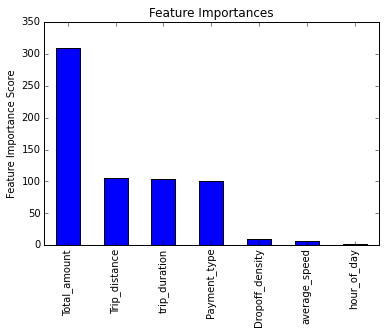

In [125]:
pd.Series(xgbrege.booster().get_fscore()).sort_values(ascending=False).plot(kind='bar', title='Feature Importances')
ylabel('Feature Importance Score')

Pickle and dump the fitted model and check the performance after the saved model is reloaded from disk:

#### Below is the code for testing

In [32]:
import joblib
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from numpy import sqrt

class TaxiTipPercent():
    '''
    Tip-percentage prediction with xgboost. Here, I assume the test data have the same
    format with the training data "green_tripdata_2015-09.csv",
    '''
    _training_filename = "green_tripdata_2015-09.csv"
    _model_filename = "xgbmodel.pkl"
    _pickup_dropoff_density_filename = "count.pkl"
    _train_validate_ratio = 0.9  # 10% of the train data will be used for validation
    _x_columnname = ['VendorID', 'Payment_type', 'Passenger_count', 'Trip_distance', 'Extra',
                     'average_speed', 'Total_amount', 'hour_of_day', 'trip_duration',
                     'lpep_pickup_datetime', 'Pickup_density', 'Dropoff_density']
    _y_columnname = ['tip_percent']

    def __init__(self, test_filename):
        try:
            (self.min_lat, self.max_lat, self.min_lon, self.max_lon, self.resolution_lat, self.resolution_lon,
             self.count) = joblib.load(self._pickup_dropoff_density_filename)
            self.xgbmodel = joblib.load(self._model_filename)
        except:
            self.train_model()

        self.filename = test_filename
        df = pd.read_csv(self.filename, sep=',')
        self.data_cleaning(df)
        if "Tip_amount" in df.columns:
            df['tip_percent'] = df.Tip_amount / df.Total_amount * 100
            df_shuffled = df[(df.trip_duration >= 30) & (df.Total_amount >= 0) &
                             (df.Trip_distance > 0) & (df.Total_amount > 0)
                             ][self._x_columnname + self._y_columnname].dropna()
        else:
            df_shuffled = df[(df.trip_duration >= 30) & (df.Total_amount >= 0) &
                             (df.Trip_distance > 0) & (df.Total_amount > 0)
                             ][self._x_columnname].dropna()
        df_shuffled['VendorID'] = (df_shuffled.VendorID == 1).astype(int)
        df_shuffled['Payment_type'] = (df.Payment_type == 1).astype(int)
        df_shuffled['lpep_pickup_datetime'
                   ] = pd.to_datetime(df.lpep_pickup_datetime).apply(lambda x: x.isoweekday() < 6).astype(int)
        test_x = df_shuffled[self._x_columnname]
        df_shuffled['prediction'] = self.xgbmodel.predict(test_x)
        self.df = df_shuffled
        if self._y_columnname[0] in df_shuffled.columns:
            test_y = df_shuffled[self._y_columnname]
            print 'Test score:', self.xgbmodel.score(test_x, test_y)
            print 'Test mean square error:', sqrt(mean_squared_error(test_y, self.xgbmodel.predict(test_x)))

    def data_cleaning(self, df):
        df['hour_of_day'] = ((pd.to_datetime(df.Lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)) / 2 +
                             pd.to_datetime(df.lpep_pickup_datetime)).apply(lambda x: x.hour)
        trip_dur = pd.to_datetime(df.Lpep_dropoff_datetime) - pd.to_datetime(df.lpep_pickup_datetime)
        df['trip_duration'] = [int(x.total_seconds()) for x in trip_dur]
        df['Pickup_density'] = map(lambda x: 0 if self.get_coordinate(x) == -1 else self.count[self.get_coordinate(x)],
                                   zip(df.Pickup_latitude, df.Pickup_longitude))
        df['Dropoff_density'] = map(lambda x: 0 if self.get_coordinate(x) == -1 else self.count[self.get_coordinate(x)],
                                    zip(df.Dropoff_latitude, df.Dropoff_longitude))
        df['average_speed'] = df.Trip_distance / df.trip_duration

    def get_coordinate(self, latlon):
        if latlon[0] == 0 or latlon[1] == 0:
            return -1
        if (latlon[0] <= self.min_lat or latlon[0] >= self.max_lat or
            latlon[1] <= self.min_lon or latlon[1] >= self.max_lon):
            return -1
            
        return (int((latlon[0] - self.min_lat) / self.resolution_lat),
                int((latlon[1] - self.min_lon) / self.resolution_lon))

    def pickup_dropoff_density(self, df):

        valid_latlon = df[(df.Pickup_latitude > 0) &
                          (df.Dropoff_latitude > 0)][['Pickup_latitude', 'Pickup_longitude',
                                                      'Dropoff_latitude', 'Dropoff_longitude']]
        self.min_lat = min(min(valid_latlon.Pickup_latitude), min(valid_latlon.Dropoff_latitude)) - 0.000001
        self.max_lat = max(max(valid_latlon.Pickup_latitude), max(valid_latlon.Dropoff_latitude)) + 0.000001
        self.min_lon = min(min(valid_latlon.Pickup_longitude), min(valid_latlon.Dropoff_longitude)) - 0.000001
        self.max_lon = max(max(valid_latlon.Pickup_longitude), max(valid_latlon.Dropoff_longitude)) + 0.000001
        self.resolution_lat = (self.max_lat - self.min_lat) / 2000
        self.resolution_lon = (self.max_lon - self.min_lon) / 2000

        count = np.zeros([2000, 2000], dtype=int)
        positions = (zip(df.Pickup_latitude, df.Pickup_longitude) +
                     zip(df.Dropoff_latitude, df.Dropoff_longitude))
        for latlon in positions:
            coord = self.get_coordinate(latlon)
            if coord != -1:
                count[coord] += 1
        self.count = count

    def train_model(self):
        try:
            df = pd.read_csv(self._training_filename, sep=',')
        except:
            import urllib
            urllib.urlretrieve(r'https://s3.amazonaws.com/nyc-tlc/trip+data/' +
                               self._training_filename, self._training_filename)
            df = pd.read_csv(self._training_filename, sep=',')

        self.pickup_dropoff_density(df)
        self.data_cleaning(df)

        df['tip_percent'] = df.Tip_amount/df.Total_amount * 100
        df_shuffled = df[(df.trip_duration >= 30) & (df.Total_amount >= 0) &
                         (df.Trip_distance > 0) & (df.Total_amount > 0)
                         ][self._x_columnname + self._y_columnname].dropna().sample(frac=1)
        df_shuffled['VendorID'] = (df_shuffled.VendorID == 1).astype(int)
        df_shuffled['Payment_type'] = (df.Payment_type == 1).astype(int)
        df_shuffled['lpep_pickup_datetime'] = pd.to_datetime(df.lpep_pickup_datetime
                                                             ).apply(lambda x: x.isoweekday() < 6
                                                                     ).astype(int)
        train = df_shuffled[:int(len(df_shuffled) * self._train_validate_ratio)]
        test = df_shuffled[int(len(df_shuffled) * self._train_validate_ratio):]
        train_x, train_y = train[self._x_columnname], train[self._y_columnname]
        test_x, test_y = test[self._x_columnname], test[self._y_columnname]

        xgbrege = XGBRegressor(subsample=0.65, learning_rate=0.04, max_depth=3, base_score=0.5)
        xgbrege.fit(train_x, list(train_y.tip_percent))
        joblib.dump(xgbrege, self._model_filename)
        countcsv = (self.min_lat, self.max_lat, self.min_lon, self.max_lon,
                    self.resolution_lat, self.resolution_lon, self.count)
        joblib.dump(countcsv, self._pickup_dropoff_density_filename)
        self.xgbmodel = xgbrege

        print 'Validation score:', xgbrege.score(test_x, test_y)
        print 'Validation mean square error:', sqrt(mean_squared_error(test_y, xgbrege.predict(test_x)))


###### Below I used the green taxi data from Oct. 2015 to test my model, as shown the correlation score reaches 0.74

In [35]:
test_filename = "green_tripdata_2015-10.csv"
test_res = TaxiTipPercent(test_filename).df

Test score: 0.741866370781
Test mean square error: 4.43804468678


# Question 5

### Option B: Visualization
#### Can you build a visualization (interactive or static) of the trip data that helps us understand intra- vs. inter-borough traffic? What story does it tell about how New Yorkers use their green taxis?

In [2]:
def download_and_preprocessing(download=False):
    '''
    Part 1: Download the data
    Part 2: Get the county information and Borough information of the trip
            Here I modified Ajay Thampi's reverse-geocoder library to extact Boroughs from
            GPS coordinates. Since original library follows a LGPL license, I will open source
            the file when the data chanlledge is fully finished.
            https://github.com/thampiman/reverse-geocoder
    '''
    
    if download:
        filename = download_logfiles(['green', '.csv'])
     
    import reverse_geocoder as rg
    import pandas as pd
    import numpy as np
    import os

    usecols = ['lpep_pickup_datetime', 'Lpep_dropoff_datetime',
               'Pickup_latitude', 'Pickup_longitude',
               'Dropoff_latitude', 'Dropoff_longitude',
               'Passenger_count']
    dfs = pd.concat(pd.read_csv(filename, sep=',', usecols=usecols, index_col=False) for filename in
                    sorted(fn for fn in os.listdir("./") if fn.find("tripdata") >= 0 and fn.find(".csv") >= 0))

    dfs = dfs[dfs.Pickup_latitude.notnull() & dfs.Pickup_longitude.notnull() &
              dfs.Dropoff_latitude.notnull() & dfs.Pickup_longitude.notnull()]
    dfs = dfs[dfs.lpep_pickup_datetime.notnull() & dfs.Lpep_dropoff_datetime.notnull()]
    dfs = dfs[dfs.Passenger_count.notnull()]

    dfs = dfs[(dfs.Pickup_latitude != 0) & (dfs.Pickup_longitude != 0) &
              (dfs.Dropoff_latitude != 0) & (dfs.Pickup_longitude != 0)]

    dfs['pickup_location'] = zip(dfs.Pickup_latitude, dfs.Pickup_longitude)
    dfs['dropoff_location'] = zip(dfs.Dropoff_latitude, dfs.Dropoff_longitude)

    county2borough = {'New York County':'Manhattan',
                      'Bronx':'The Bronx',
                      'Queens County':'Queens',
                      'Kings County':'Brooklyn',
                      'Richmond County':'Staten Island'}
    
    # Here we used a modified library of "Reverse geocoding to find the county name of the
    # pickup and dropoff locations, since each county corresponds to a Borough, we map it
    # to the correct Borough
    
    # The modified reverse geocoder will download all the geoinformation of Gazetteers in 
    # United States, i.e. a hospital, a shop, a park, a church, etc. Then for a given GPS
    # coordinate, we will find its closest gazetteer using a K-D tree. The the county name
    # of the gazetteer will be returned.
    get_borough = lambda location: map(lambda x: county2borough.get(x['admin2'], 'Other'), rg.search(list(location)))

    dfs['pickup_borough'] = get_borough(dfs.pickup_location)
    dfs['dropoff_borough'] = get_borough(dfs.dropoff_location)

    dfs = dfs[(dfs.pickup_borough != 'Other') | (dfs.dropoff_borough != 'Other')]
    dfs.reset_index(inplace=True, drop=True)
    del dfs['Pickup_latitude']; del dfs['Pickup_longitude']; del dfs['Dropoff_latitude']; del dfs['Dropoff_longitude']; 
    dfs.to_csv('trip_borough.csv', index=False)
    # print len(dfs)
    return dfs


def preprocessing2():
    # determine the inter/intra-Borough trips, determine the time, prepare for visualization
    import pandas as pd
    import numpy as np

    dfs = pd.read_csv('trip_borough.csv', index_col=False)

    sec_since_midnight = lambda t: t.hour*3600 + t.minute*60 + t.second
    dfs['pickup_second'] = pd.to_datetime(dfs.lpep_pickup_datetime).apply(sec_since_midnight)
    dfs['dropoff_second'] = pd.to_datetime(dfs.Lpep_dropoff_datetime).apply(sec_since_midnight)

    del dfs['lpep_pickup_datetime']; del dfs['Lpep_dropoff_datetime'];
    borough_index = {"Manhattan": 1, "Brooklyn": 2, "Queens": 3, "The Bronx": 4, "Staten Island": 5, "Other": 0}
    dfs['inter_intra'] = (dfs.pickup_borough != dfs.dropoff_borough).astype(int)
    dfs['pickup_borough'].replace(borough_index, inplace=True)
    dfs['dropoff_borough'].replace(borough_index, inplace=True)

    dfs.to_csv('trip_borough_update.csv', index=False)

    
def drawframe(i, interval_gap=120):
    '''
    draw the frame of a given "timestamp"
    
    Parameters:
    i --> the i_th frame
    '''
    import matplotlib.pyplot as plt
    import pandas as pd
    fig_size = (8, 8)
    df = pd.read_csv("plotdata_%d.csv" % i, sep=',', index_col=False,
                     header=None, names=['lat', 'lon', 'pickup_dropoff',
                                         'inter_intra', 'other_end'])
    colors = ['b', 'y', 'c', 'r']
    fig = plt.figure()
    fig.set_size_inches(fig_size[0], fig_size[1])
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    pickup_inter_df = df[(df.pickup_dropoff == 0) & (df.inter_intra == 0)]
    pickup_intra_df = df[(df.pickup_dropoff == 0) & (df.inter_intra == 1)]
    dropoff_inter_df = df[(df.pickup_dropoff == 1) & (df.inter_intra == 0)]
    dropoff_intra_df = df[(df.pickup_dropoff == 1) & (df.inter_intra == 1)]
    fig1, = plt.plot(dropoff_inter_df.lon, dropoff_inter_df.lat,
                     colors[0] + '.', markersize=0.75)
    fig2, = plt.plot(dropoff_intra_df.lon, dropoff_intra_df.lat,
                     colors[1] + '.', markersize=0.75)
    fig3, = plt.plot(pickup_inter_df.lon, pickup_inter_df.lat,
                     colors[2] + '.', markersize=0.75)
    fig4, = plt.plot(pickup_intra_df.lon, pickup_intra_df.lat,
                     colors[3] + '.', markersize=0.75)
    legend_labels = (r'Inter-Borough Pickups', r'Intra-Borough Pickups',
                     r'Inter-Borough Dropoffs', r'Intra-Borough Dropoffs')
    legend_here = plt.legend((fig3, fig4, fig1, fig2), legend_labels,
                             loc=2, fontsize=14, columnspacing=-5, numpoints=1,
                             borderpad=0.2, labelspacing=0.1)
    legend_here.get_frame().set_facecolor('None')
    legend_here.get_frame().set_edgecolor('None')
    legend_texts = legend_here.get_texts()
    legend_texts[0].set_color(colors[2])
    legend_texts[1].set_color(colors[3])
    legend_texts[2].set_color(colors[0])
    legend_texts[3].set_color(colors[1])

    legend_here.legendHandles[0]._legmarker.set_markersize(8)
    legend_here.legendHandles[1]._legmarker.set_markersize(8)
    legend_here.legendHandles[2]._legmarker.set_markersize(8)
    legend_here.legendHandles[3]._legmarker.set_markersize(8)
    seconds_today = i * interval_gap
    if seconds_today < 86400 / 2:
        time_str = "%02d:%02d AM" % (
            seconds_today / 3600, seconds_today % 3600 / 60)
    else:
        time_str = "%02d:%02d PM" % (
            seconds_today / 3600, seconds_today % 3600 / 60)
    plt.text(-73.80, 40.608, time_str, color='white', fontsize=18)
    plt.axis([-74.05, -73.75, 40.6, 40.9])
    plt.savefig('%05d.png' % i, dpi=125, facecolor='black')
    plt.draw()
    plt.clf()
    return 1


def draw_movie(movie_filename="movie.mp4"):
    '''
    First, draw a scatter plot of inter/intra-Borough pickups and dropoffs for each "timestamp"
    Then, we will call FFmpeg to merge images to a video.
    '''
    import pandas as pd
    import os
    os.system("rm plotdata_*.csv")

    dfs = pd.read_csv('trip_borough_update.csv', index_col=False)

    interval_gap = 120  # each frame in the video corresponds to 60 sec logs
    fp_file = [open("plotdata_%d.csv" % i, 'w') for i in range(86400/interval_gap)]

    for record in dfs.iterrows():
        record = record[1]
        pickup_t_index, dropoff_t_index = record.pickup_second/interval_gap, record.dropoff_second/interval_gap
        fp_file[pickup_t_index].write("%s,%s,%d,%d,%d\n" % 
                                      (record.pickup_location[1:-1].split(", ")[0],
                                       record.pickup_location[1:-1].split(", ")[1],
                                       0, record.inter_intra, record.dropoff_borough))
        fp_file[dropoff_t_index].write("%s,%s,%d,%d,%d\n" %
                                       (record.dropoff_location[1:-1].split(", ")[0],
                                        record.dropoff_location[1:-1].split(", ")[1],
                                        1, record.inter_intra, record.pickup_borough))
    for fp in fp_file:
        fp.close()

    for i in range(86400/interval_gap):  # draw frames
        drawframe(i, interval_gap=interval_gap)
    
    # combine frames to a video using FFmpeg
    os.system("ffmpeg -i %05d.png -c:a copy -c:v libx264 -crf 18 -preset veryslow " + movie_filename)

def visualization_video(movie_filename="movie.mp4"):
    '''
    Here we clean the memory multiple times due to out-of-memory issues,
    since we are using all of the green taxi logs. (2013-2016)
    If given more time, I will write a better documentation
    
    Parameters:
    movie_filename --> the filename fo the to-be-generated video
    '''
    import gc

    download_and_preprocessing(download=True)
    gc.collect()

    preprocessing2()
    gc.collect()

    draw_movie(movie_filename="movie.mp4")
    gc.collect()

In [3]:
visualization_video(movie_filename="movie.mp4")

Above function will download all the NYC green taxi GPS logs (2013-2016), and visualize the pickup-dropoff in a video.

Here we used a modified library of **Reverse geocoder** to find the county name of the pickup and dropoff locations (GPS corrdinates). Since each county corresponds to a Borough, we then map them to the correct Boroughs.   
The modified reverse geocoder will download all the geo-information of **Gazetteers** in United States, i.e. hospitals, shops, restaurants, schools, etc. Then for a given GPS coordinate, we will find its closest gazetteer using KD trees. The the county name of the gazetteer will be returned.
The code will generate a visualization **video** for the inter/intra-Borough pickups/dropoffs. A compressed version of the video **movie_compressed.mp4** is sent along with the email.
Runing the code may take very long time, since it will download all the green taxi logs, US gazetteer data, and build KD Trees, can generate frames.

In [55]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

def plot_borough_trip():
    x_list = ['BK', 'BX', 'MN', 'QN', 'SI',
              'BK>BX', 'BK>MN', 'BK>O', 'BK>QN', 'BK>SI',
              'BX>BK', 'BX>MN', 'BX>O', 'BX>QN', 'BX>SI',
              'MN>BK', 'MN>BX', 'MN>O', 'MN>QN', 'MN>SI',
              'QN>BK', 'QN>BX', 'QN>MN', 'QN>O', 'QN>SI',
              'SI>BK', 'SI>BX', 'SI>MN', 'SI>O', 'SI>QN',
              'O>BK', 'O>BX', 'O>MN', 'O>QN', 'O>SI']
    try:
        plot_data_dict = joblib.load('plot_data_dict.pkl')
    except:
        dfs = pd.read_csv('trip_borough.csv', index_col=False)
        dfs['inter_intra'] = (dfs.pickup_borough != dfs.dropoff_borough).astype(int)
        abbv = {'Brooklyn':'BK', 'The Bronx': 'BX', 'Queens': 'QN',
                'Staten Island': 'SI', 'Manhattan': 'MN', 'Other': 'O'}
        dfs['pickup_borough'].replace(abbv, inplace=True)
        dfs['dropoff_borough'].replace(abbv, inplace=True)
        dfs['inter-intra-ori-tar'] = dfs.pickup_borough + ('>' + dfs.dropoff_borough) * dfs.inter_intra
        plot_data = dfs.groupby('inter-intra-ori-tar').size()
        plot_data_dict=dict(plot_data)
        joblib.dump(plot_data_dict, 'plot_data_dict.pkl')

    plotdat = map(lambda x: plot_data_dict[x], x_list)   
    sns.set(style="whitegrid")
    fig = figure()
    fig.set_size_inches(16, 10)
    barh(np.arange(5)-0.5, plotdat[:5], color='r')
    barh(np.arange(5)+4.5, plotdat[5:10], color='silver')
    barh(np.arange(5)+9.5, plotdat[10:15], color='lightgreen')
    barh(np.arange(5)+14.5, plotdat[15:20], color='lightyellow')
    barh(np.arange(5)+19.5, plotdat[20:25], color='cyan')
    barh(np.arange(5)+24.5, plotdat[25:30], color='pink')
    barh(np.arange(5)+29.5, plotdat[30:35], color='lightblue')
    xscale('log')
    yticks(range(len(plotdat)),x_list,size=14)
    xticks(size=16)
    axis([1, 1e8, len(x_list), -1])
    ylabel('Borough', size=18)
    xlabel('Occupacy', size=18)
    savefig("plot_borough_trip.png", dpi=100)
    show()

In [56]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Below is the bar chart of the inter/intra-borough trips. The intra-borough trips are colored as red. Here I again used all the green taxi data from 2013 to 2016.

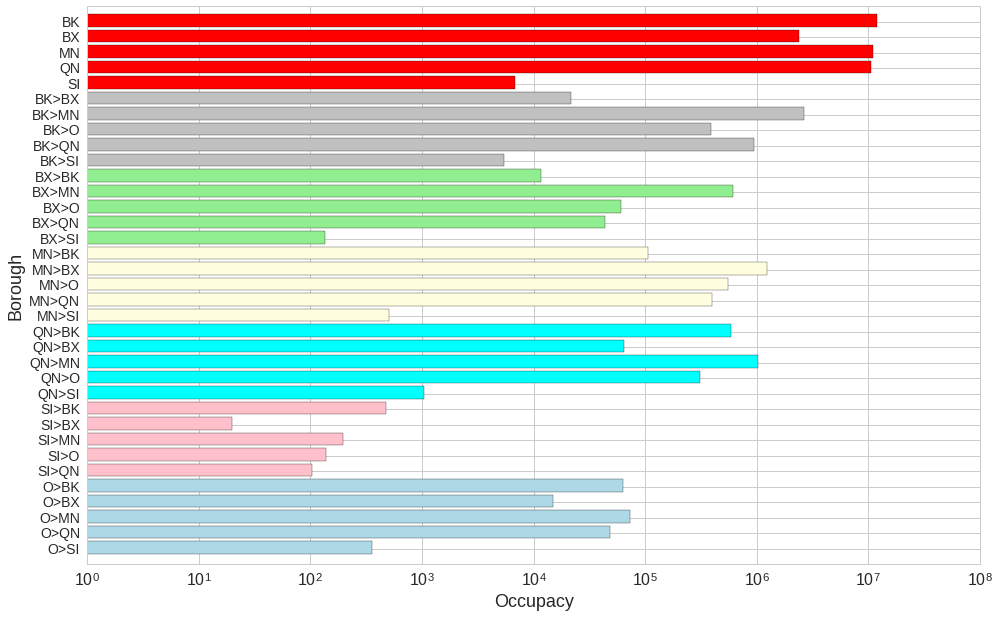

In [57]:
plot_borough_trip()

From the figure above, clearly most taxi trips are intar-Borough, as marked red in above figure. Also I found that Manhattan has the most inter-Borough dropoffs, and Staten Island has the least. On the other hand, from the visualization video, I found a clear time-dependent variation.